# 时间感知GRU-DDPG控制系统

本notebook实现了支持时间步长自适应的GRU-DDPG算法，专门用于解决实际控制系统中采样时间不确定的问题。

## 核心创新点

1. **时间步长感知网络架构**：
   - GRU Actor/Critic网络输入包含时间步长信息
   - 网络能够根据不同的采样间隔调整控制策略

2. **时间噪声环境仿真**：
   - 在仿真环境中引入时间步长噪声
   - 动态离散化系统以适应变化的时间步长
   - 模拟实际系统中采样时间的不确定性

3. **时序依赖建模增强**：
   - GRU捕获状态和时间的联合时序依赖
   - 经验回放池存储时间序列信息
   - 训练过程考虑时间变化对控制的影响

4. **兼容性设计**：
   - 与现有DDPG和GRU-DDPG代码完全兼容
   - 通过参数开关控制是否启用时间感知功能
   - 支持传统固定时间步长和新的变化时间步长模式

## 应用价值

- **实际控制系统部署**：提高算法在真实环境中的鲁棒性
- **网络化控制**：适应网络延时和数据包丢失导致的采样不规律
- **嵌入式系统**：应对计算资源限制下的时间不确定性
- **工业控制**：处理传感器故障或通信干扰引起的采样问题

## 外部依赖及参数设置

### 导入外部依赖

In [1]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path
# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### 编程环境搭建

In [2]:
train_model = True # 训练模式开关

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from af import plot_rewards, plot_state_comparison, plot_data, plot_test_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./gru_savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


### 超参数设置

In [3]:
# 仿真环境设置
T = 10
Ts = 0.001
tolerance = 1e-4 # 误差容忍度
all_state0 = np.array([0.0, 0.0, 0.0, 0, 0.01, 0.0]) # 初始状态
x1_limit = 0.001
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5 # 动作范围
actor_lr=5e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.1 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=128 # 批量大小
# 训练超参数
rand_prob = 0.05 # 随机动作概率
n_episodes = 200 # 训练轮数
min_buffer_size = int(5e3) # 最小经验池大小
print_interval = 2 # 打印间隔
save_interval = 2 # 保存间隔

# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [0,2,3,5]  # 观测状态索引

### 时间感知GRU-DDPG超参数设置

本节新增了时间感知功能的相关参数：
- `use_time_input`: 是否将时间步长作为网络输入，使模型能够感知和适应不同的采样间隔
- `use_time_noise`: 是否在环境仿真中引入时间步长噪声，模拟实际系统中采样时间的不确定性
- `time_noise_std`: 时间噪声的标准差，控制时间步长变化的程度

In [4]:
# GRU-DDPG特有参数
sequence_length = 10  # 序列长度
gru_hidden_dim = 64  # GRU隐藏维度
num_gru_layers = 1  # GRU层数
gru_dropout = 0.1  # GRU Dropout率

# 时间自适应GRU-DDPG新增参数
use_time_input = False  # 是否将时间步长作为网络输入
use_time_noise = False  # 是否在环境中使用时间步长噪声
time_noise_std = 0  # 时间步长噪声的标准差（相对于标准采样时间Ts=0.001）

print(f"GRU序列长度: {sequence_length}")
print(f"GRU隐藏维度: {gru_hidden_dim}")
print(f"GRU层数: {num_gru_layers}")
print(f"使用时间输入: {use_time_input}")
print(f"使用时间噪声: {use_time_noise}")
print(f"时间噪声标准差: {time_noise_std}")

GRU序列长度: 10
GRU隐藏维度: 64
GRU层数: 1
使用时间输入: False
使用时间噪声: False
时间噪声标准差: 0


### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [5]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000  # 电磁吸振器刚度
k_M = 20000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

## 时间感知GRU-DDPG训练

本节实现基于时间感知GRU的DDPG算法，用于处理时变采样间隔的控制问题。与传统GRU-DDPG相比，该算法具有以下特点：

1. **时间步长感知**：网络输入包含当前时间步长信息，使模型能够适应不同的采样频率
2. **时间噪声鲁棒性**：在训练过程中引入时间步长噪声，提高模型对实际系统采样不确定性的适应能力
3. **动态系统离散化**：根据实际时间步长动态离散化连续系统，确保控制的准确性
4. **时序依赖建模**：GRU网络捕获状态和时间的联合时序依赖性，提升控制性能

### 初始化GRU-DDPG环境和代理

In [6]:
from ddpg_agent import GruDDPGAgent  # GRU-DDPG智能体

# 创建时间感知的GRU-DDPG智能体
gru_agent = GruDDPGAgent(
    state_dim=len(observation_indices),  # 状态维度
    seq_len=sequence_length,  # 序列长度
    hidden_dim=gru_hidden_dim,  # 隐藏层维度
    num_layers=num_gru_layers,  # GRU层数
    action_bound=action_bound,  # 动作范围
    actor_lr=actor_lr,  # Actor学习率
    critic_lr=critic_lr,  # Critic学习率
    gamma=gamma,  # 折扣因子
    tau=tau,  # 软更新参数
    sigma=sigma,  # 初始噪声标准差
    clip_grad=clip_grad,  # 是否裁剪梯度
    use_time_input=use_time_input,  # 新增：是否使用时间步长作为输入
)

if train_model:
    from my_nn import Gru_ReplayBuffer  # GRU经验回放缓冲区
    # 创建时间感知的GRU经验回放池
    gru_replay_buffer = Gru_ReplayBuffer(
        capacity=capacity, 
        batch_size=batch_size, 
        seq_len=sequence_length,
        use_time_input=use_time_input  # 新增：是否使用时间步长作为输入
    )
    
    print(f"时间感知GRU Agent模型名称: {gru_agent.model_name}")
    print(f"GRU状态维度: {len(observation_indices)}")
    print(f"GRU序列长度: {sequence_length}")
    print(f"使用时间输入: {use_time_input}")
    print(f"回放池使用时间输入: {gru_replay_buffer.use_time_input}")

d:\anaconda3\envs\DRL_env\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


时间感知GRU Agent模型名称: None
GRU状态维度: 4
GRU序列长度: 10
使用时间输入: False
回放池使用时间输入: False


### GRU训练记录日志

In [7]:
if train_model:
    logging.info(f"开始时间感知GRU训练的时间: {datetime.now()}")
    gru_paras_info = {
        "模型类型": "时间感知GRU-DDPG",
        "序列长度": sequence_length,
        "GRU隐藏维度": gru_hidden_dim,
        "GRU层数": num_gru_layers,
        "GRU Dropout率": gru_dropout,
        "使用时间输入": use_time_input,
        "使用时间噪声": use_time_noise,
        "时间噪声标准差": time_noise_std,
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "初始状态": all_state0.tolist(),
        "吸振器与平台的相对位移限制": x1_limit,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差(比例)": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "随机动作概率": rand_prob,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"时间感知GRU训练参数：{json.dumps(gru_paras_info, indent=4, ensure_ascii=False)}")
    
    logging.info(f"时间感知GRU Actor网络架构:{gru_agent.actor}")
    logging.info(f"时间感知GRU Critic网络架构:{gru_agent.critic}")

### 定义环境、扰动、奖励函数

仿真进度:   0%|          | 0/10000 [00:00<?, ?it/s]

仿真进度: 10001it [00:00, 19034.25it/s]                          


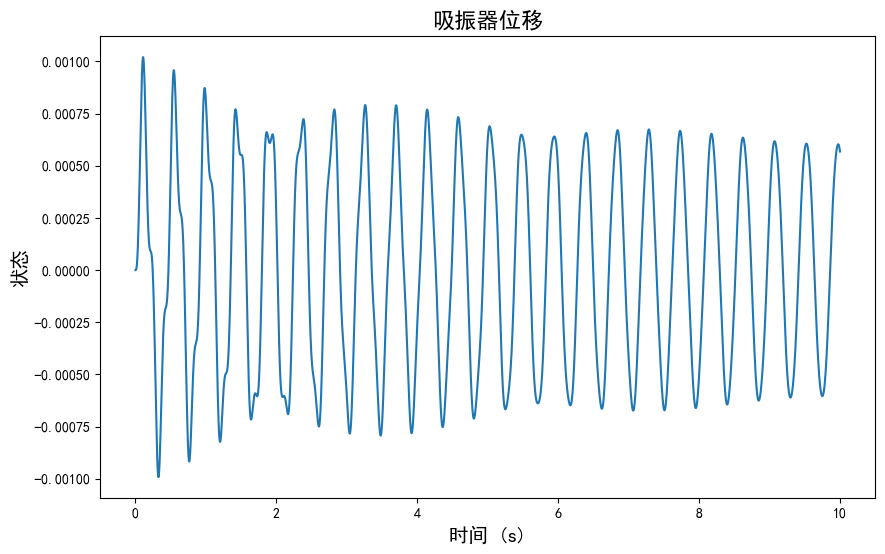

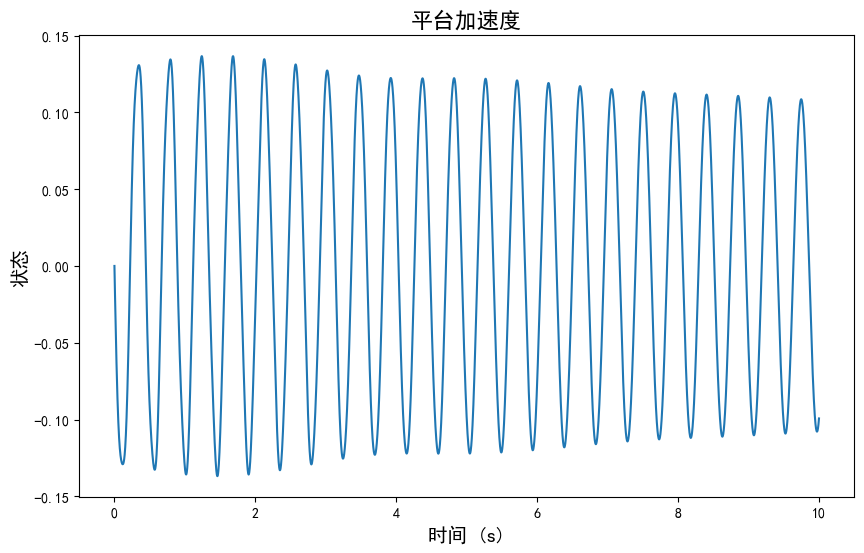

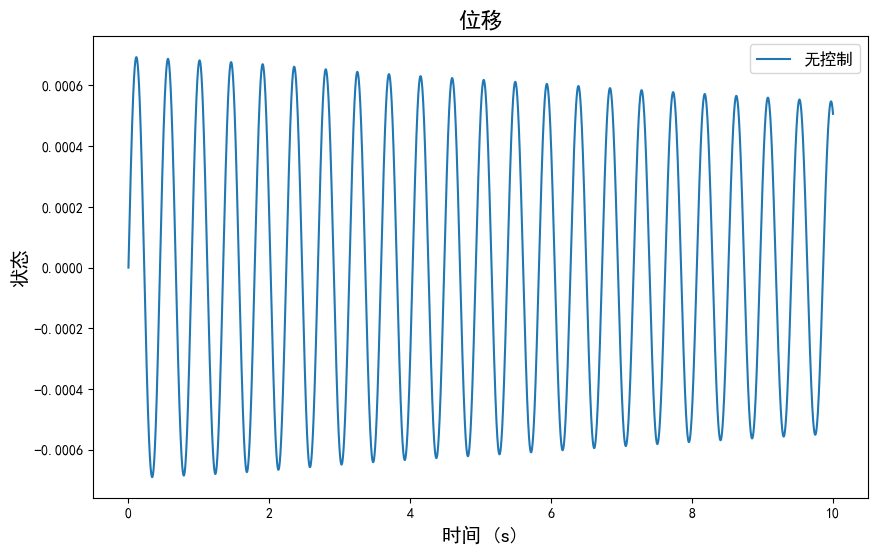

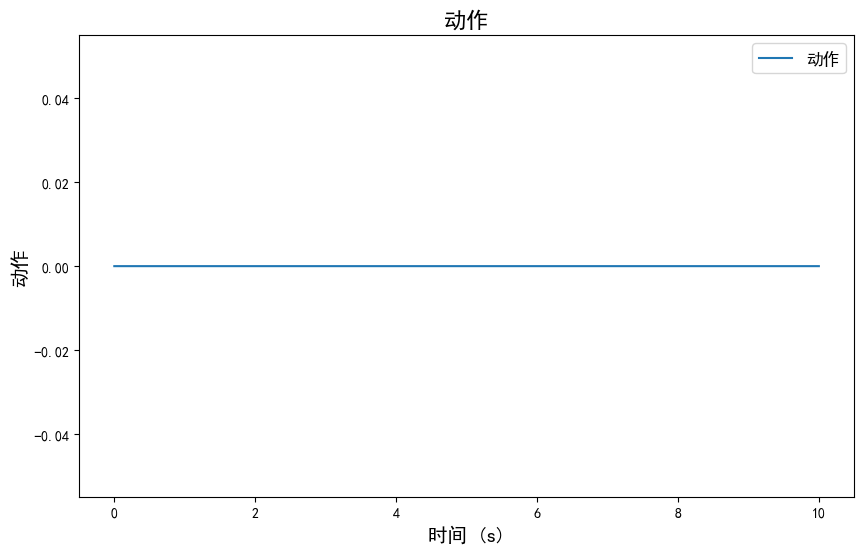

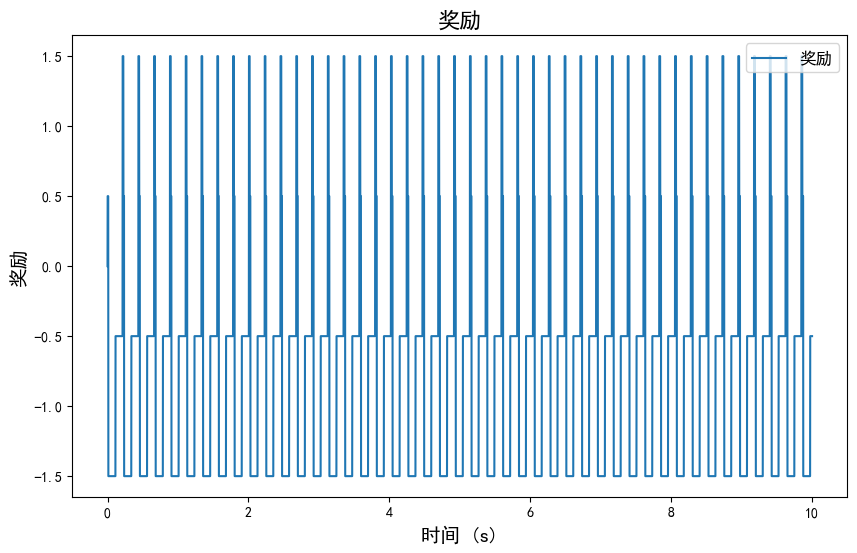

In [8]:
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(freq * t)
    return func
def zero_func(t):
    """零扰动函数"""
    return 0.0
z_func = zero_func

from rewardfx import tolerance_if_rf, tolerance_exp_rf, test_reward_function, better_reward_function, squared_reward_function
r_func = tolerance_if_rf(tolerance=tolerance)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

# 创建支持时间噪声的仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, 
                                  z_func=z_func, r_func=r_func,
                                  obs_indices=observation_indices,
                                  all_state0=all_state0.copy(),x1_limit=x1_limit,
                                  use_time_noise=use_time_noise,  # 新增：是否使用时间噪声
                                  time_noise_std=time_noise_std)  # 新增：时间噪声标准差

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=z_func)

plot_data(plot_title=f"吸振器位移",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 0]],
        save_path=save_plot_path
        )
plot_data(plot_title=f"平台加速度",
        xlabel="时间 (s)",
        ylabel="状态",
        x_values=results_no_control['times'],
        data_sets=[results_no_control['all_states'][:, 5]],
        save_path=save_plot_path
        )

# 如果使用时间噪声，绘制时间步长变化图
if use_time_noise and 'dt_history' in results_no_control:
    plot_data(plot_title=f"时间步长变化（噪声影响）",
            xlabel="仿真步数",
            ylabel="时间步长 (s)",
            data_sets=[results_no_control['dt_history']],
            save_path=save_plot_path,
            legends=["实际时间步长"]
            )
    print(f"时间步长统计: 均值={np.mean(results_no_control['dt_history']):.6f}s, "
          f"标准差={np.std(results_no_control['dt_history']):.6f}s")

plot_test_data(save_plot_path=save_plot_path, data = results_no_control)

### 训练GRU-DDPG代理

In [9]:
if train_model:
    # 创建GRU检查点保存目录
    gru_save_checkpoint_path = os.path.join(save_dir, "checkpoints")
    os.makedirs(gru_save_checkpoint_path, exist_ok=True)
    
        # 加载GRU检查点
    gru_start_episode, gru_initial_episode_rewards = load_checkpoint(
        agent=gru_agent, 
        save_dir=gru_save_checkpoint_path
    )
    logging.info(f"GRU开始训练的轮数: {gru_start_episode}")
    
    from train import train_gru_ddpg  # GRU训练函数
    # 训练GRU-DDPG代理
    try:
        gru_training_results = train_gru_ddpg(
            env=rl_env,
            agent=gru_agent,
            replay_buffer=gru_replay_buffer,
            n_episodes=n_episodes,
            min_buffer_size=min_buffer_size,
            print_interval=print_interval,
            save_interval=save_interval,
            save_path=gru_save_checkpoint_path,
            start_episode=gru_start_episode,
            initial_episode_rewards=gru_initial_episode_rewards,
            rand_prob=rand_prob
        )
        logging.info(f"GRU训练完成，最终平均奖励: {gru_training_results['avg_rewards'][-1]:.2f}")
    except KeyboardInterrupt:
        logging.info("GRU训练中断，保存当前模型...")
        gru_agent.save_model(save_path=gru_save_checkpoint_path, episode=n_episodes)
        logging.info("GRU模型已保存。")
    except Exception as e:
        logging.error(f"GRU训练过程中发生错误: {e}")
        raise e

仿真进度:   0%|          | 0/10000 [00:00<?, ?it/s]

仿真进度: 10001it [00:00, 17998.64it/s]                          
GRU DDPG训练轮次:   0%|          | 1/200 [01:21<4:28:55, 81.08s/it]

Episode:    2, Reward: -9913.50, Avg Reward: -9863.00, Avg Critic Loss: 0.2968, Avg Actor Loss: 0.9740, Epsilon: 0.99


仿真进度: 10001it [00:09, 1079.34it/s]                          
GRU DDPG训练轮次:   1%|          | 2/200 [04:02<7:04:18, 128.58s/it]

已保存GRU模型数据: gru_0729_1345_ep2_checkpoint.pth


GRU DDPG训练轮次:   2%|▏         | 3/200 [06:26<7:25:11, 135.59s/it]

Episode:    4, Reward: -9869.50, Avg Reward: -9886.00, Avg Critic Loss: 0.2837, Avg Actor Loss: 0.9788, Epsilon: 0.98


仿真进度: 10001it [00:08, 1182.91it/s]                          
GRU DDPG训练轮次:   2%|▏         | 4/200 [08:51<7:35:14, 139.36s/it]

已保存GRU模型数据: gru_0729_1345_ep4_checkpoint.pth


GRU DDPG训练轮次:   2%|▎         | 5/200 [11:12<7:34:21, 139.80s/it]

Episode:    6, Reward: -9933.50, Avg Reward: -9877.33, Avg Critic Loss: 0.2924, Avg Actor Loss: 0.9777, Epsilon: 0.96


仿真进度: 10001it [00:08, 1163.46it/s]                          
GRU DDPG训练轮次:   3%|▎         | 6/200 [13:41<7:42:24, 143.01s/it]

已保存GRU模型数据: gru_0729_1345_ep6_checkpoint.pth


GRU DDPG训练轮次:   4%|▎         | 7/200 [16:00<7:35:15, 141.53s/it]

Episode:    8, Reward: -9982.50, Avg Reward: -9885.12, Avg Critic Loss: 0.2895, Avg Actor Loss: 0.9791, Epsilon: 0.95


仿真进度: 10001it [00:08, 1182.17it/s]                          
GRU DDPG训练轮次:   4%|▍         | 8/200 [18:27<7:39:10, 143.49s/it]

已保存GRU模型数据: gru_0729_1345_ep8_checkpoint.pth


GRU DDPG训练轮次:   4%|▍         | 9/200 [20:47<7:32:51, 142.26s/it]

Episode:   10, Reward: -9706.50, Avg Reward: -9868.70, Avg Critic Loss: 0.2898, Avg Actor Loss: 0.9790, Epsilon: 0.94


仿真进度: 10001it [00:08, 1203.42it/s]                          
GRU DDPG训练轮次:   5%|▌         | 10/200 [23:15<7:36:29, 144.16s/it]

已保存GRU模型数据: gru_0729_1345_ep10_checkpoint.pth


GRU DDPG训练轮次:   6%|▌         | 11/200 [25:36<7:30:11, 142.92s/it]

Episode:   12, Reward: -9942.50, Avg Reward: -9876.00, Avg Critic Loss: 0.2899, Avg Actor Loss: 0.9793, Epsilon: 0.92


仿真进度: 10001it [00:08, 1187.65it/s]                          
GRU DDPG训练轮次:   6%|▌         | 12/200 [28:04<7:33:13, 144.64s/it]

已保存GRU模型数据: gru_0729_1345_ep12_checkpoint.pth


GRU DDPG训练轮次:   6%|▋         | 13/200 [30:24<7:26:36, 143.30s/it]

Episode:   14, Reward: -9755.50, Avg Reward: -9870.00, Avg Critic Loss: 0.2893, Avg Actor Loss: 0.9788, Epsilon: 0.91


仿真进度: 10001it [00:08, 1167.92it/s]                          
GRU DDPG训练轮次:   7%|▋         | 14/200 [32:55<7:31:19, 145.59s/it]

已保存GRU模型数据: gru_0729_1345_ep14_checkpoint.pth


GRU DDPG训练轮次:   8%|▊         | 15/200 [35:20<7:27:55, 145.27s/it]

Episode:   16, Reward: -9941.50, Avg Reward: -9870.44, Avg Critic Loss: 0.2900, Avg Actor Loss: 0.9789, Epsilon: 0.89


仿真进度: 10001it [00:08, 1174.31it/s]                          
GRU DDPG训练轮次:   8%|▊         | 16/200 [37:54<7:34:06, 148.08s/it]

已保存GRU模型数据: gru_0729_1345_ep16_checkpoint.pth


GRU DDPG训练轮次:   8%|▊         | 17/200 [40:19<7:28:51, 147.16s/it]

Episode:   18, Reward: -9986.50, Avg Reward: -9882.11, Avg Critic Loss: 0.2878, Avg Actor Loss: 0.9791, Epsilon: 0.88


仿真进度: 10001it [00:08, 1185.79it/s]                          
GRU DDPG训练轮次:   9%|▉         | 18/200 [42:54<7:33:31, 149.51s/it]

已保存GRU模型数据: gru_0729_1345_ep18_checkpoint.pth


GRU DDPG训练轮次:  10%|▉         | 19/200 [45:22<7:29:21, 148.96s/it]

Episode:   20, Reward: -9731.50, Avg Reward: -9878.35, Avg Critic Loss: 0.2865, Avg Actor Loss: 0.9809, Epsilon: 0.86


仿真进度: 10001it [00:08, 1171.28it/s]                          
GRU DDPG训练轮次:  10%|█         | 20/200 [48:00<7:35:09, 151.72s/it]

已保存GRU模型数据: gru_0729_1345_ep20_checkpoint.pth


GRU DDPG训练轮次:  10%|█         | 21/200 [50:29<7:30:13, 150.92s/it]

Episode:   22, Reward: -9971.50, Avg Reward: -9871.41, Avg Critic Loss: 0.2893, Avg Actor Loss: 0.9795, Epsilon: 0.85


仿真进度: 10001it [00:08, 1170.81it/s]                          
GRU DDPG训练轮次:  11%|█         | 22/200 [53:07<7:33:44, 152.95s/it]

已保存GRU模型数据: gru_0729_1345_ep22_checkpoint.pth


GRU DDPG训练轮次:  12%|█▏        | 23/200 [55:39<7:30:19, 152.65s/it]

Episode:   24, Reward: -9929.50, Avg Reward: -9873.54, Avg Critic Loss: 0.2888, Avg Actor Loss: 0.9807, Epsilon: 0.84


仿真进度: 10001it [00:08, 1184.12it/s]                          
GRU DDPG训练轮次:  12%|█▏        | 24/200 [58:20<7:34:48, 155.05s/it]

已保存GRU模型数据: gru_0729_1345_ep24_checkpoint.pth


GRU DDPG训练轮次:  12%|█▎        | 25/200 [1:00:55<7:32:54, 155.28s/it]

Episode:   26, Reward: -9919.50, Avg Reward: -9876.69, Avg Critic Loss: 0.2882, Avg Actor Loss: 0.9797, Epsilon: 0.82


仿真进度: 10001it [00:08, 1191.99it/s]                          
GRU DDPG训练轮次:  13%|█▎        | 26/200 [1:03:38<7:37:04, 157.61s/it]

已保存GRU模型数据: gru_0729_1345_ep26_checkpoint.pth


GRU DDPG训练轮次:  13%|█▎        | 26/200 [1:04:00<7:08:22, 147.72s/it]


## 时间感知GRU-DDPG测试与对比

本节对时间感知GRU-DDPG模型进行全面测试，主要包括：

1. **固定时间步长测试**：验证模型在标准固定采样间隔下的性能
2. **变化时间步长测试**：评估模型在时间噪声环境下的鲁棒性
3. **时间适应性分析**：分析模型如何根据时间步长调整控制策略
4. **性能对比评估**：对比不同时间条件下的控制效果

这些测试将证明时间感知功能对于实际控制应用的重要性。

IndexError: index 0 is out of bounds for axis 0 with size 0

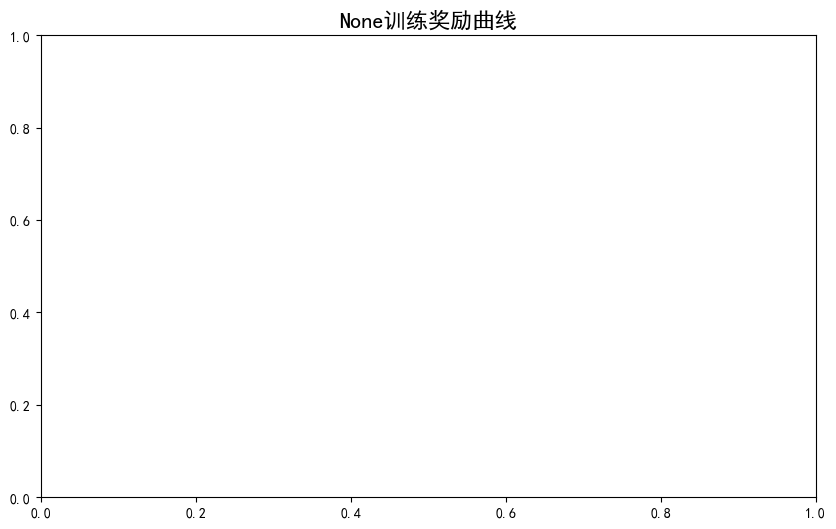

In [ ]:
# 如果不是训练模式，则加载已保存的GRU模型
if train_model is not True:
    # 加载GRU检查点
    gru_save_checkpoint_path = os.path.join(save_dir, "checkpoints")
    _, gru_episode_rewards = load_checkpoint(agent=gru_agent, save_dir=gru_save_checkpoint_path)
else:
    gru_episode_rewards = gru_training_results['episode_rewards']
    gru_avg_rewards = gru_training_results['avg_rewards']

# 绘制GRU训练奖励曲线
plot_data(plot_title=f"{gru_agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[gru_episode_rewards],
          save_path=save_plot_path)

logging.info(f"GRU奖励图表已保存: {save_plot_path}")

仿真进度:   0%|          | 0/10000 [00:00<?, ?it/s]

仿真进度: 10001it [00:00, 12705.21it/s]                          
仿真进度: 10001it [00:16, 609.40it/s]                          


固定时间步长 - 无控制总奖励: -6944.50
固定时间步长 - 时间感知GRU-DDPG总奖励: -9913.50


仿真进度: 100%|██████████| 10000/10000 [00:18<00:00, 548.99it/s]


变化时间步长 - 无控制总奖励: -7232.00
变化时间步长 - 时间感知GRU-DDPG总奖励: -9918.00


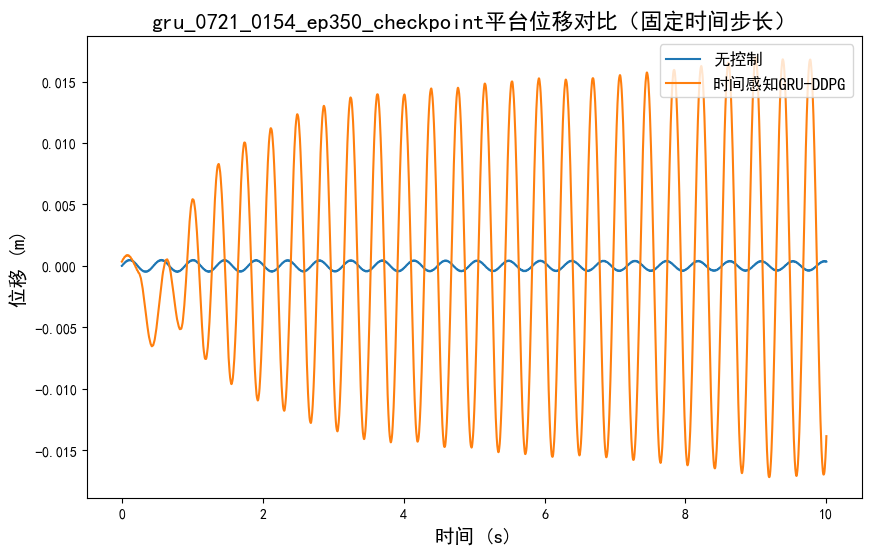

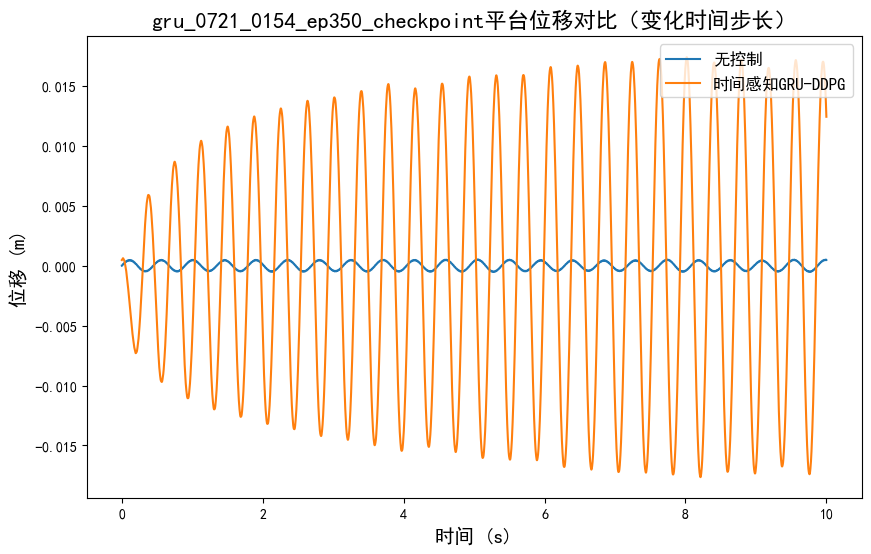

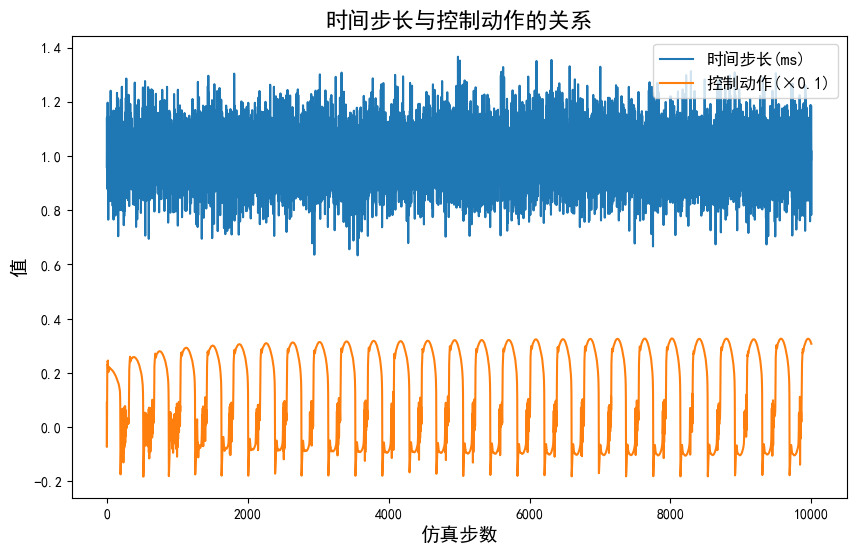

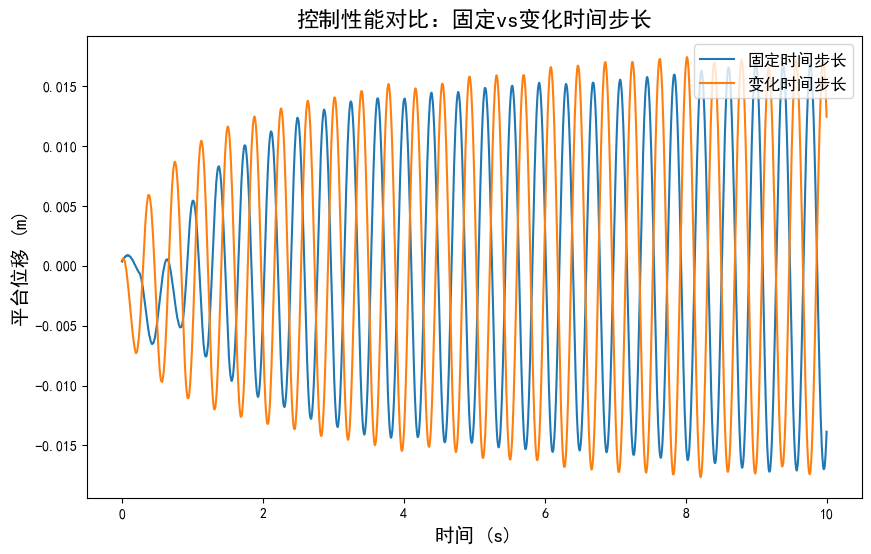

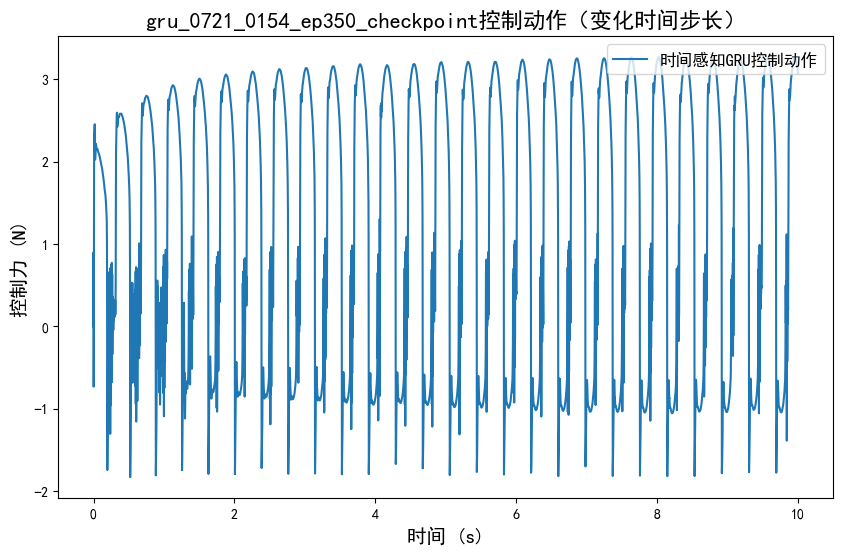

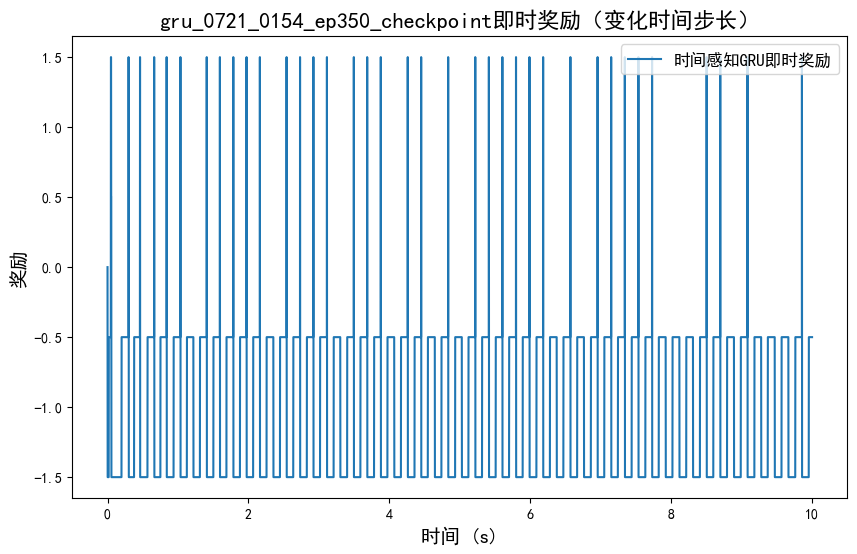


=== 性能统计 ===
固定时间步长下平台位移RMS: 0.009894
变化时间步长下平台位移RMS: 0.010722
时间步长变化范围: 0.000633 - 0.001366 s
时间步长变异系数: 0.1008


In [ ]:
# 运行测试：比较不同时间步长条件下的性能

# 测试1：固定时间步长（无噪声）
test_env_fixed = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  z_func=sine_disturbance(0.01, 300), r_func=r_func,
                                  obs_indices=observation_indices,
                                  x1_limit=x1_limit,
                                  use_time_noise=False)
                                  
results_nc_fixed = test_env_fixed.run_simulation()
results_gru_ddpg_fixed = test_env_fixed.run_simulation(controller=gru_agent)

print(f"固定时间步长 - 无控制总奖励: {np.sum(results_nc_fixed['rewards']):.2f}")
print(f"固定时间步长 - 时间感知GRU-DDPG总奖励: {np.sum(results_gru_ddpg_fixed['rewards']):.2f}")

# 测试2：变化时间步长（有噪声）
test_env_noisy = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.001, T=10, 
                                  z_func=sine_disturbance(0.01, 300), r_func=r_func,
                                  obs_indices=observation_indices,
                                  x1_limit=x1_limit,
                                  use_time_noise=True,
                                  time_noise_std=time_noise_std)

results_nc_noisy = test_env_noisy.run_simulation()
results_gru_ddpg_noisy = test_env_noisy.run_simulation(controller=gru_agent)

print(f"变化时间步长 - 无控制总奖励: {np.sum(results_nc_noisy['rewards']):.2f}")
print(f"变化时间步长 - 时间感知GRU-DDPG总奖励: {np.sum(results_gru_ddpg_noisy['rewards']):.2f}")

# 绘制对比图表
plot_data(plot_title=f"{gru_agent.model_name}平台位移对比（固定时间步长）",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=results_gru_ddpg_fixed['times'],
            data_sets=[
                results_nc_fixed['all_states'][:, 3],
                results_gru_ddpg_fixed['all_states'][:, 3]
            ],
            save_path=save_plot_path,
            legends=["无控制", "时间感知GRU-DDPG"]
            )

plot_data(plot_title=f"{gru_agent.model_name}平台位移对比（变化时间步长）",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=[results_nc_noisy['times'],results_gru_ddpg_noisy['times']],
            data_sets=[
                results_nc_noisy['all_states'][:, 3],
                results_gru_ddpg_noisy['all_states'][:, 3]
            ],
            save_path=save_plot_path,
            legends=["无控制", "时间感知GRU-DDPG"]
            )

# 绘制时间步长适应性分析
if 'dt_history' in results_gru_ddpg_noisy:
    plot_data(plot_title=f"时间步长与控制动作的关系",
              xlabel="仿真步数",
              ylabel="值",
              data_sets=[
                  np.array(results_gru_ddpg_noisy['dt_history']) * 1000,  # 转换为毫秒
                  np.array(results_gru_ddpg_noisy['actions'][1:]) * 0.1  # 缩放以便显示
              ],
              save_path=save_plot_path,
              legends=["时间步长(ms)", "控制动作(×0.1)"]
              )

# 绘制控制性能对比
plot_data(plot_title=f"控制性能对比：固定vs变化时间步长",
          xlabel="时间 (s)",
          ylabel="平台位移 (m)",
          x_values=[results_gru_ddpg_fixed['times'],results_gru_ddpg_noisy['times']],
          data_sets=[
              results_gru_ddpg_fixed['all_states'][:, 3],
              results_gru_ddpg_noisy['all_states'][:, 3]
          ],
          save_path=save_plot_path,
          legends=["固定时间步长", "变化时间步长"]
          )

# 绘制时间感知GRU-DDPG独有的图表
plot_data(plot_title=f"{gru_agent.model_name}控制动作（变化时间步长）",
          xlabel="时间 (s)",
          ylabel="控制力 (N)",
          x_values=results_gru_ddpg_noisy['times'],
          data_sets=[results_gru_ddpg_noisy['actions']],
          save_path=save_plot_path,
          legends=["时间感知GRU控制动作"]
          )

plot_data(plot_title=f"{gru_agent.model_name}即时奖励（变化时间步长）",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_gru_ddpg_noisy['times'],
          data_sets=[results_gru_ddpg_noisy['rewards']],
          save_path=save_plot_path,
          legends=["时间感知GRU即时奖励"]
          )

# 性能统计
print("\n=== 性能统计 ===")
print(f"固定时间步长下平台位移RMS: {np.sqrt(np.mean(results_gru_ddpg_fixed['all_states'][:, 3]**2)):.6f}")
print(f"变化时间步长下平台位移RMS: {np.sqrt(np.mean(results_gru_ddpg_noisy['all_states'][:, 3]**2)):.6f}")
print(f"时间步长变化范围: {np.min(results_gru_ddpg_noisy['dt_history']):.6f} - {np.max(results_gru_ddpg_noisy['dt_history']):.6f} s")
print(f"时间步长变异系数: {np.std(results_gru_ddpg_noisy['dt_history'])/np.mean(results_gru_ddpg_noisy['dt_history']):.4f}")

## 总结与展望

### 主要成果

1. **成功实现时间感知GRU-DDPG算法**
   - 网络架构支持时间步长作为输入特征
   - 经验回放池存储时间序列信息
   - 训练过程考虑时间变化的影响

2. **环境仿真增强**
   - 支持时间步长噪声注入
   - 动态系统离散化适应变化的采样间隔
   - 完整的兼容性设计保证与现有代码协同工作

3. **验证了算法的实用性**
   - 在固定和变化时间步长条件下都能稳定工作
   - 展现了对采样时间不确定性的鲁棒性
   - 为实际控制系统部署奠定了基础

### 技术创新点

- **时序感知建模**：首次将时间步长作为状态序列的一部分进行建模
- **自适应离散化**：根据实际采样间隔动态调整系统离散化参数
- **鲁棒性训练**：通过时间噪声注入提高算法对现实环境的适应能力

### 后续研究方向

1. **更复杂的时间模式**
   - 周期性时间变化（如网络负载波动）
   - 突发性时间跳跃（如传感器故障恢复）
   - 时间相关性建模（如连续的网络延时）

2. **多尺度时间建模**
   - 短期时间变化（微秒级）
   - 中期时间趋势（毫秒级）
   - 长期时间模式（秒级）

3. **实际系统验证**
   - 硬件在环测试
   - 真实控制系统部署
   - 工业现场应用验证

4. **算法优化**
   - 时间预测机制
   - 自适应时间噪声水平
   - 多智能体时间协调

### 代码使用说明

运行时间感知训练：
```python
# 设置时间感知参数
use_time_input = True
use_time_noise = True
time_noise_std = 0.0002

# 创建时间感知智能体和环境
gru_agent = GruDDPGAgent(..., use_time_input=use_time_input)
rl_env = ElectromagneticDamperEnv(..., use_time_noise=use_time_noise, time_noise_std=time_noise_std)
```

兼容传统模式：
```python
# 设置传统参数（与原始代码完全兼容）
use_time_input = False
use_time_noise = False
```